# Amphibian dermal exposure model - Bayesian inference
***

In this notebook we will try to fit a simple amphibian dermal exposure model to data from lab tests.


## The model
***

\begin{equation*}
Predicted\_tissue\_conc = \frac{(app\_rate * surface\_area * conv\_rate * \mathbf{dermal\_af)}}{body\_weight}
\end{equation*}


We will focus on fitting one important but poorly understood parameter: **dermal_af**, which describes the fraction of amphibian surface area that comes in contact with the soil medium. 

Our method for inferring this paramter's distribution will be a simple Metropolis-Hastings MCMC algorithm.

## The data set
***

In [1]:
# import data 
combined_data <- read.csv('../data_out/amphib_dermal_collated.csv')
# delete 593:601 -- check application units
combined_data_drops <- combined_data[-(593:601),]
head(combined_data)


X,app_rate_g_cm2,application,body_weight_g,chemical,exp_duration,formulation,sample_id,soil_conc_ugg,soil_type,source,species,tissue_conc_ugg
1,5.58e-06,Overspray,1.73625,Imidacloprid,8,0,HGOI1,0.4798464,PLE,rvm2015,Barking treefrog,1.0152872
2,5.58e-06,Overspray,2.61111,Imidacloprid,8,0,HGOI2,0.4798464,PLE,rvm2015,Barking treefrog,1.6360832
3,5.58e-06,Overspray,1.82332,Imidacloprid,8,0,HGOI3,0.4798464,PLE,rvm2015,Barking treefrog,0.9261004
4,5.58e-06,Overspray,2.91551,Imidacloprid,8,0,HGOI4,0.4798464,PLE,rvm2015,Barking treefrog,0.7182776
5,5.58e-06,Overspray,2.49115,Imidacloprid,8,0,HGOI5,0.4798464,PLE,rvm2015,Barking treefrog,1.0890361
6,2.00e-05,Overspray,2.09766,Pendimethalin,8,0,HGOP1,12.1193484,PLE,rvm2015,Barking treefrog,2.1387952


Initialize some constants:

In [2]:
n <- length(combined_data_drops$tissue_conc_ugg)
app_rate <- combined_data_drops$app_rate_g_cm2
body_weight <- combined_data_drops$body_weight_g
tissue_conc <- combined_data_drops$tissue_conc_ugg #observed tissue concs
conv_rate <- 1000000.0
sa_tim_default_frac <- 0.5
sa_amphib_hutchinson <- 1.131 * (body_weight ^ 0.579)
dermal_af = 0.5 #This is one value that has been used in the past
sd = 2
pred = (app_rate * conv_rate * sa_amphib_hutchinson * sa_tim_default_frac * dermal_af)/body_weight

summary(body_weight)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1879  1.1315  1.8342  2.9861  2.5535 23.3405 

## Defining the prior distributions
***

We need to define what we think we know about the possibel values of dermal_af, as well as the random error s.d.

We will start with wide uniform priors:
* dermal_af: uniform from 0 to 10
* sd: uniform from 0 to 10

In [3]:
# returns the prior probability for a set of dermal_af and sd values
prior <- function(param){
  a = param[1]
  sd = param[2]
  aprior = dunif(a, min=0, max=10, log = T)
  sdprior = dunif(sd, min=0, max=10, log = T)
  return(aprior+sdprior)
}

## Defining the likelihood function
***

We will assume a normally-distributed error term, with unknown sd. So our likelihood function will be univariate (log)normal.

In [4]:
# the likelihood is the probability (density) with which we would expect the 
# observed data to occur conditional on the parameters of the model that we look at
likelihood <- function(param){
  dermal_af = param[1]
  sd = param[2]
  
  # pred = a*x + b
  pred = (app_rate * conv_rate * sa_amphib_hutchinson * sa_tim_default_frac * dermal_af)/body_weight
  # the probability of obtaining the test data above under this model
  # we simply calculate the difference between predictions the predicted y and 
  # the observed y, and then we have to look up the probability densities (using dnorm) 
  # for such deviations to occur
  singlelikelihoods = dnorm(tissue_conc, mean = pred, sd = sd, log = T)
  # sum the likelihoods across all the obeserved differences
  # we sum the logs as convention to avoid numerical issues, etc.
  sumll = sum(singlelikelihoods)
  return(sumll)   
}

## Defining the posterior function
***
The posterior is, by definition, the likelihood times the prior. Since we are working with log-likelihoods, we will add these terms.

In [5]:
posterior <- function(param){
  return (likelihood(param) + prior(param))
}

## The Metropolis-Hastings MCMC Algorithm
***
First we need a function that takes a current parameter set and gives a new proposal set.

The s.d. in this function is often called the 'step length', and can be tuned to adjust the acceptance rate.

In [6]:
proposalfunction <- function(param){
  return(rnorm(2,mean = param, sd= c(0.1,0.3)))
}

Finally, we can define our Metropolis-Hastings MCMC function

In [7]:
run_metropolis_MCMC <- function(startvalue, iterations){
  chain = array(dim = c(iterations+1,3))
  chain[1,1:2] = startvalue
  for (i in 1:iterations){
    # create candidate inputs
    proposal = proposalfunction(chain[i,1:2])
    
    # compare the new simulation to the previous one
    probab = exp(posterior(proposal) - posterior(chain[i,1:2]))
    
    # decide to accept or reject the proposal
    if (runif(1) < probab){
      chain[i+1,1:2] = proposal #accept the new proposal
    }else{
      chain[i+1,1:2] = chain[i,1:2] #reject the new proposal and keep the previous one
    }
    chain[i+1,3] <- probab # save the acceptance probability in the chain
  }
  return(chain)
}

## Running the MCMC sampler
***
OK, we are ready to do some inference on dermal_af using our empirical data and our Metropolis-Hastings algorithm.

In [8]:
startvalue = c(1,2) # NOTE: we should draw these from the priors right?
iterations = 100000
chain = run_metropolis_MCMC(startvalue, iterations)
dim(chain)
summary(chain)
burnIn = 50000 # discard these initial steps due to burn in period
acceptance = 1-mean(duplicated(chain[-(1:burnIn),1:2]))
acceptance
chain_burnfree <- chain[-(1:burnIn),]
chain_burnfree[which(chain_burnfree[,3]>1),3] <- 1


[1] 100001      3

       V1               V2              V3           
 Min.   :0.1647   Min.   :2.000   Min.   :0.0000000  
 1st Qu.:0.2719   1st Qu.:6.265   1st Qu.:0.0000001  
 Median :0.2873   Median :6.374   Median :0.0011452  
 Mean   :0.2872   Mean   :6.375   Mean   :      Inf  
 3rd Qu.:0.3020   3rd Qu.:6.484   3rd Qu.:0.1223191  
 Max.   :1.0000   Max.   :7.179   Max.   :      Inf  
                                  NA's   :1          

[1] 0.1632567

## Visualize the output
***

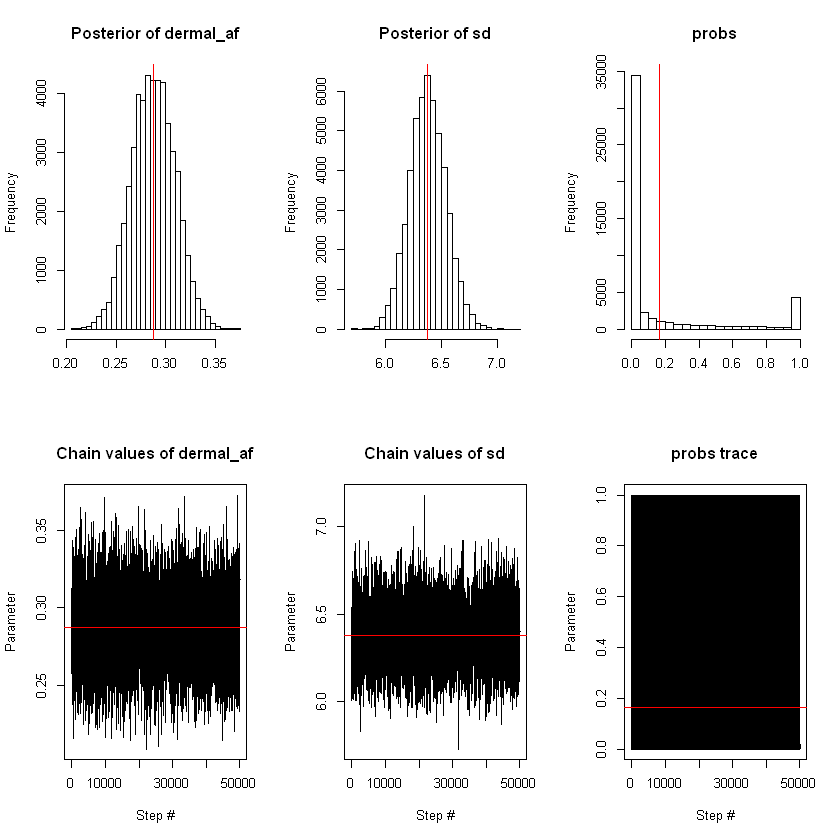

In [9]:
par(mfrow = c(2,3))
hist(chain_burnfree[,1],nclass=30, , main="Posterior of dermal_af", xlab="")
abline(v = mean(chain_burnfree[,1]), col="red")
hist(chain_burnfree[,2],nclass=30, main="Posterior of sd", xlab="")
abline(v = mean(chain_burnfree[,2]), col="red" )
hist(chain_burnfree[,3],nclass=30, main="probs", xlab="")
abline(v = mean(chain_burnfree[,3]), col="red" )
plot(chain_burnfree[,1], type = "l", xlab="Step #" , ylab = "Parameter", main = "Chain values of dermal_af", )
abline(h = mean(chain_burnfree[,1]), col="red" )
plot(chain_burnfree[,2], type = "l", xlab="Step #" , ylab = "Parameter", main = "Chain values of sd", )
abline(h = mean(chain_burnfree[,2]), col="red" )
plot(chain_burnfree[,3], type = "l", xlab="Step #" , ylab = "Parameter", main = "probs trace", )
abline(h = mean(chain_burnfree[,3]), col="red" )